AAAAAAAAAAAAAAAAAAAAAAAAAAA




MY MATH IS WRONGITHWREGPI@ERJW"
**From**

   $$
     a(x-n)^{2}+b(y-m)^{2}+cxy \;=\; d .
   $$


**Solve for $c$**

$$
  \boxed{\,c=\dfrac{\,d-a(x-n)^{2}-b(y-m)^{2}\,}{xy}\,}
  \qquad\bigl(x\neq 0,\;y\neq 0\bigr).
$$

Showing $c$ equals the residual uniquely whenever $xy$ is non‑zero; otherwise, the $c$ term implodes as the $xy$ denominator vanishes and further information about the specific conic or application is needed.



Does each locat
 __ __
|[][]
|[][]


 n1, m1
 n2, m2


In [11]:
import imageio
import numpy as np
from skimage.draw import ellipse
import os
import cv2
import time
import math
print("Done Importing")

notebook_directory = os.getcwd()

print(f"Notebook directory: {notebook_directory}")

#was going to use float32 given that the final results are in uint8 and the former gives 7
#and float32 gives 7 decimal places of accuracy but the critical use to avoid cancellation error in  the following  c_coeff
"""
    VERY NUMERICALLY CRAZY BAD
        theta = np.deg2rad(angle_deg%360)
        cos_t = np.cos(theta)
        sin_t = np.sin(theta)

        a_coeff = (cos_t / semi_a) ** 2 + (sin_t / semi_b) ** 2
        b_coeff = (sin_t / semi_a) ** 2 + (cos_t / semi_b) ** 2
        c_coeff = 2 * sin_t * cos_t * (1/semi_a**2 - 1/semi_b**2)

"""

    #diff  = (b_hat - a_hat) * (b_hat + a_hat)
    #denom = (a_hat * a_hat) * (b_hat * b_hat)
    #delta  = diff / denom if abs(diff) > _DOUBLE_TINY else 0.0

# the product underflows for the diff and denom  underflow to float32 subnormal
# also reciprical- squares can exceed normal range
# rounding noise may accumulate past 7 decimal places
_DOUBLE_EPS  = np.finfo(np.float64).eps     # ≈ 2.22e‑16
_DOUBLE_TINY = np.finfo(np.float64).tiny    # ≈ 2.23e‑308



def ellipse_params_to_general_form(center_x: float,
                                   center_y: float,
                                   semi_a: float,
                                   semi_b: float,
                                   angle_deg: float,
                                   *,
                                   circle_rel_eps: float | None = None):
    """
    Parameters
              
    - center_x, center_y : float
        - Ellipse centre (h, k).
    - semi_a, semi_b : float
        - Semi‑major / semi‑minor axes *in pixels* (must be > 0).
    - angle_deg : float
        - Rotation angle theta in degrees.
    - circle_rel_eps : float or None, optional
        - Relative tolerance for deciding the ellipse is a circle.  If *None*
        (default), we use 2*machine ε(≈4.4e-16).  A value of, say,  1e‑8 duplicates the common graphics‑library threshold.
    """
    if semi_a <= 0 or semi_b <= 0:
        raise ValueError("semi_a and semi_b must be positive")


    semi_a   = np.float64(semi_a)
    semi_b   = np.float64(semi_b)
    center_x = np.float64(center_x)
    center_y = np.float64(center_y)

    #rel_diff threshold
    rel_eps = (2.0 * _DOUBLE_EPS) if circle_rel_eps is None else np.float64(circle_rel_eps)

    #circle shortcut – if |a - b| <= rel_eps * max(a, b), treat as circle.
    if abs(semi_a - semi_b) <= rel_eps * max(semi_a, semi_b):
        r      = np.float64(0.5) * (semi_a + semi_b)
        inv_r2 = np.float64(1.0) / (r * r)
        return {
            "a": inv_r2,  # A
            "b": inv_r2,  # C (equal for a circle)
            "c": np.float64(0.0),  # B
            "d": np.float64(1.0),
            "h": center_x,
            "w": center_y,
        }

    scale  = np.float64(max(semi_a, semi_b))
    a_hat, b_hat = semi_a / scale, semi_b / scale   #to bound 0 < a_hat, b_hat <= 1

    #b_hat or a_hat just means "normalized and i could be 1 or smaller"
    inv_a2 = np.float64(1.0) / (a_hat * a_hat)
    inv_b2 = np.float64(1.0) / (b_hat * b_hat)

    #c_coeff = 2 * sin_t * cos_t * (1/semi_a**2 - 1/semi_b**2)
    #init used this one but there is cancellation error in the parentheses so i made
    # delta, inv1 and inv2 for numerical stabilityinv_a2 = 1.0 / (a*a)
    #delta used later

    theta = np.deg2rad(angle_deg % 360)
    sin_t, cos_t = math.sin(theta), math.cos(theta)

    theta  = math.radians(angle_deg % 360.0)
    sin_t  = math.sin(theta)
    cos_t  = math.cos(theta)

    #                                                                   
    # 3Stable product for Δ = 1/a² − 1/b²  (avoids catastrophic cancellation)
    #     Δ = (b_hat − a_hat)(b_hat + a_hat) / (a_hat² b_hat²)
    #     Underflow safeguard: if Δ under‑flows to zero at float64, we can
    #     safely snap B to zero – numerically, the ellipse is essentially
    #     axis‑aligned.
    diff   = (b_hat - a_hat) * (b_hat + a_hat)
    denom  = (a_hat * a_hat) * (b_hat * b_hat)
    delta  = diff / denom if abs(diff) > _DOUBLE_TINY else 0.0
    1/semi_a**2 - 1/semi_b**2

    # coeffs - minimize rounding with fma
    sc = math.fma(sin_t, cos_t, 0.0) if hasattr(math, "fma") else sin_t * cos_t
    B  = 2.0 * sc * delta

    A  = (cos_t * cos_t) * inv_a2 + (sin_t * sin_t) * inv_b2
    C  = (sin_t * sin_t) * inv_a2 + (cos_t * cos_t) * inv_b2

    #undo rescaling - coeff for original pixel units
    scale2 = scale * scale
    A     /= scale2
    B     /= scale2
    C     /= scale2

    return {
        "a": A,
        "b": C,
        "c": B,
        "d": np.float64(1.0),
        "h": center_x,
        "w": center_y,
    }


Done Importing
Notebook directory: C:\Users\epw268\Documents\GitHub\yeastReverseImageSegmentation


In [4]:
def generate_uint8_labels(w: int, h: int, cells_data: dict,
                          *, use_vectorized: bool = True) -> np.ndarray:
    """
    Parameters:

    - w, h : int
        - Output image width and height **in pixels**.
    - cells_data : dict
        Expected structure::

            {
                "indices":      [1, 2, ...],              # uint8 IDs (1‑255)
                "fluorescence": [0.42, 0.17, ...],        # ignored here
                "shape":        [(a1, b1), (a2, b2), ...],
                "location":     [(x1, y1), (x2, y2), ...],
                "rotation":     [theta1, theta2, ...]             # degrees
            }

        - ``'indices'`` must contain unique integers <= 255.  All lists must be
        the same length.
    - use_vectorized : bool, default ``True``
        If ``True`` masks are generated with :func:`create_ellipse_mask_vectorized`.
        If ``False`` the pixel‑loop variant is used (slower, but easier to
        debug).


    Returns:
    - uint8_labels: np.ndarray of shape (h, w) with dtype=np.uint8
              -
    uint8_labels : np.ndarray, shape ``(h, w)``, dtype ``np.uint8``
        Background pixels hold 0; each ellipse interior is filled with its
        corresponding ID from ``cells_data['indices']``.

    - Notes
        - All heavy arithmetic is carried out in **float64** via
          :func:`ellipse_params_to_general_form`; conversion to ``uint8`` happens
          only at the final assignment step, ensuring numerical robustness.
        - Raises ``ValueError`` if a cell ID exceeds 255.

    """
    uint8_labels = np.zeros((h, w), dtype=np.uint8)
    #    indices,    shapes, locations,  rotations   = cells_data["indices"],  cells_data["shape"] ,   cells_data["location"], cells_data["rotation"]
    indices    = cells_data["indices"]
    shapes     = cells_data["shape"]       # list of (semi_a, semi_b)
    locations  = cells_data["location"]    # list of (x, y)
    rotations  = cells_data["rotation"]    # list of theta in degrees

    print(f"Generating uint8 labels for {len(indices)} cells...")
    print(f"Output array shape: {uint8_labels.shape}, dtype: {uint8_labels.dtype}")
    print(f"Using {'vectorized' if use_vectorized else 'mathematical'} ellipse generation")

    #mask generation method
    mask_fn = create_ellipse_mask_vectorized if use_vectorized else create_ellipse_mask_mathematical

    for cell_id, (semi_a, semi_b), (center_x, center_y), angle_rot_numbers in zip(indices, shapes, locations, rotations):
        if cell_id > 255:
            raise ValueError(f"Cell ID {cell_id} exceeds uint8 range 0‑255")

        coeffs   = ellipse_params_to_general_form(center_x, center_y, semi_a, semi_b, angle_rot_numbers)
        cell_mask = mask_fn(w, h, coeffs)
        uint8_labels[cell_mask] = cell_id

        pixel_count = np.sum(cell_mask)
        print(f"  Cell {cell_id}: center=({center_x},{center_y}), shape=({semi_a},{semi_b}), "
              f"rotation={angle_rot_numbers} number, pixels={pixel_count}")

    unique_labels = np.unique(uint8_labels)
    print(f"\nUint8 label summary:")
    print(f"  Unique values: {unique_labels}")
    print(f"  Background pixels (0): {np.sum(uint8_labels == 0)}")
    print(f"  Total labeled pixels: {np.sum(uint8_labels > 0)}")

    return uint8_labels

def _implicit_value(A: float, C: float, B: float, dx, dy):
    #compute A*dx² + C*dy² + B*dx*dy element‑wise (broadcast friendly)
    return A * dx * dx + C * dy * dy + B * dx * dy



Prototyping


In [16]:
if __name__ == "__main__":
    print("Running quick smoke tests for ellipse I/O + visualisation module…\n")

    # 1. Benchmark mathematical vs. vectorised
    compare_mask_generation_methods()

    # 2. Full pipeline on toy dataset
    labels, rgb = example_complete_pipeline()
    inspect_uint8_output(labels)
    print("Demo RGB image saved as demo_labels_vis.png\n")

    # 3. CV2 generator sanity check
    cv2_cells = {
        "indices": [1],
        "fluorescence": [0],
        "shape": [(25, 18)],
        "location": [(64, 64)],
        "rotation": [45],
    }
    cv2_labels = generate_uint8_labels_cv2(128, 128, cv2_cells)
    print("OpenCV generator produced label with unique values:", np.unique(cv2_labels))
    inspect_uint8_output(cv2_labels)
    print("All tests completed successfully.")

Running quick smoke tests for ellipse I/O + visualisation module…

=== Comparing Ellipse Mask Generation Methods ===
Image size: 128x128
Ellipse: center=(64,64), axes=(20,15), rotation=30°

Mathematical (pixel‑loop) method:
  Time: 6.72 ms | Pixels: 941

Vectorised method:
  Time: 6.72 ms | Pixels: 941
  Speedup: 1.0×

Masks identical: True
=== STEP 1: Generate uint8 labels ===

=== STEP 2: Save uint8 labels ===
Saved raw binary: yeast_segmentation.uint8
Saved NumPy array: yeast_segmentation.npy
Saved PNG: yeast_segmentation_labels.png
Saved metadata: yeast_segmentation_metadata.json

=== STEP 3: Visualise ===
Saved visualisation: yeast_segmentation_visual.png
=== Uint8 Label Array Inspection ===
Shape        : (128, 128)
Data type    : uint8
Memory       : 16384 bytes
Min | Max    : 0 | 9

Pixel counts per label:
  Background : 14279 px
  Cell 1     : 175 px
  Cell 2     : 279 px
  Cell 3     : 149 px
  Cell 4     : 347 px
  Cell 5     : 223 px
  Cell 6     : 253 px
  Cell 7     : 251

Found 86 TIFFs
MASK : 2020_3_24_AS20_1_AS18_Pos11_crop_1_im.tif
IMAGE: 2020_3_24_AS20_1_AS18_Pos11_crop_1_mask.tif
MASK : 2020_3_24_AS20_1_AS18_Pos11_crop_2_im.tif
IMAGE: 2020_3_24_AS20_1_AS18_Pos11_crop_2_mask.tif
MASK : a_reexport1_crop_1_im.tif
IMAGE: a_reexport1_crop_1_mask.tif
MASK : a_reexport2_crop_1_im.tif
IMAGE: a_reexport2_crop_1_mask.tif
MASK : a_reexport3_crop_1_im.tif
IMAGE: a_reexport3_crop_1_mask.tif
MASK : a_reexport3_crop_2_im.tif
IMAGE: a_reexport3_crop_2_mask.tif
MASK : Ahmad_frame_16_crop_1_im.tif
IMAGE: Ahmad_frame_16_crop_1_mask.tif
MASK : Ahmad_frame_16_crop_2_im.tif
IMAGE: Ahmad_frame_16_crop_2_mask.tif
MASK : Ahmad_frame_16_crop_3_im.tif
IMAGE: Ahmad_frame_16_crop_3_mask.tif
MASK : Ahmad_frame_16_crop_4_im.tif
IMAGE: Ahmad_frame_16_crop_4_mask.tif
MASK : Ahmad_frame_19_crop_1_im.tif
IMAGE: Ahmad_frame_19_crop_1_mask.tif
MASK : Ahmad_frame_19_crop_2_im.tif
IMAGE: Ahmad_frame_19_crop_2_mask.tif
MASK : Ahmad_frame_19_crop_3_im.tif
IMAGE: Ahmad_frame_19_crop_3_mask

TypeError: Invalid shape (5, 350, 400, 3) for image data

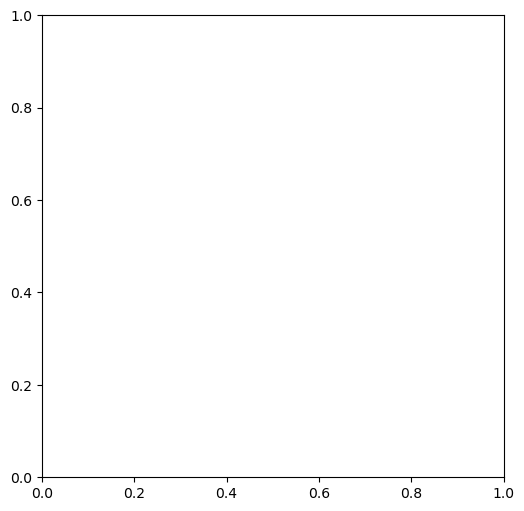